<a href="https://colab.research.google.com/github/pinilDissanayaka/Paddy-Doctor-Paddy-Disease-Classification/blob/main/ResNet50V2Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install livelossplot
!pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 5.1 MB/s eta 0:00:00


In [2]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [3]:
! kaggle datasets download ricardosalvatorelli1/paddydoctor

Dataset URL: https://www.kaggle.com/datasets/ricardosalvatorelli1/paddydoctor
License(s): unknown
100% 1.01G/1.02G [00:17<00:00, 56.9MB/s]
100% 1.02G/1.02G [00:17<00:00, 63.7MB/s]


In [4]:
! unzip paddydoctor.zip

Streaming output truncated to the last 5000 lines.
  inflating: train_images/downy_mildew/100992.jpg  
  inflating: train_images/downy_mildew/100995.jpg  
  inflating: train_images/downy_mildew/101015.jpg  
  inflating: train_images/downy_mildew/101020.jpg  
  inflating: train_images/downy_mildew/101022.jpg  
  inflating: train_images/downy_mildew/101024.jpg  
  inflating: train_images/downy_mildew/101034.jpg  
  inflating: train_images/downy_mildew/101050.jpg  
  inflating: train_images/downy_mildew/101078.jpg  
  inflating: train_images/downy_mildew/101096.jpg  
  inflating: train_images/downy_mildew/101103.jpg  
  inflating: train_images/downy_mildew/101114.jpg  
  inflating: train_images/downy_mildew/101119.jpg  
  inflating: train_images/downy_mildew/101142.jpg  
  inflating: train_images/downy_mildew/101177.jpg  
  inflating: train_images/downy_mildew/101178.jpg  
  inflating: train_images/downy_mildew/101181.jpg  
  inflating: train_images/downy_mildew/101205.jpg  
  inflating: 

In [5]:
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 7.1 MB/s eta 0:00:00


In [6]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
import seaborn as sns
import cv2
import albumentations as A

from albumentations.core.composition import Compose
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold, train_test_split

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Add, Activation
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten

from tensorflow.keras.activations import relu, softmax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array, array_to_img
from livelossplot import PlotLossesKeras

import warnings
warnings.filterwarnings(action = 'ignore')

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [7]:
import glob
from pathlib import Path

train_path = '/content/train_images'
test_path  = '/content/test_images'

print('train images')
for filepath in glob.glob(train_path + '/*/'):
    files = glob.glob(filepath + '*')
    print(f"{len(files)} \t {Path(filepath).name}")

print('test images')
for filepath in glob.glob(test_path + '/*/'):
  files = glob.glob(filepath + '*')
  print(f"{len(files)} \t {Path(filepath).name}")

files = glob.glob(test_path + '/*')
print(f"{len(files)} \t {Path(test_path).name}")

train images
380 	 bacterial_leaf_streak
620 	 downy_mildew
1088 	 tungro
1442 	 dead_heart
479 	 bacterial_leaf_blight
1738 	 blast
965 	 brown_spot
1764 	 normal
337 	 bacterial_panicle_blight
1594 	 hispa
test images
3469 	 test_images


In [8]:
SEED = 123
EPOCHS = 100
lr = 1e-4
valid_split = 0.2
input_size = 224
batch_size = 32

n_classes = len(glob.glob(train_path + '/*/'))
print(n_classes)

10


In [9]:
generator = ImageDataGenerator(rescale=1 / 255,
                                  rotation_range=10,
                                  shear_range=0.25,
                                  zoom_range=0.1,
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                  validation_split=valid_split,
#                                   preprocessing_function=get_transforms_train
                                 )

train_datagen = generator.flow_from_directory(train_path,
                                              target_size=(input_size, input_size),
                                              batch_size=batch_size,
                                              subset='training',
                                              seed=SEED)

valid_datagen = generator.flow_from_directory(train_path,
                                              target_size=(input_size, input_size),
                                              batch_size=batch_size,
                                              subset='validation',
                                              seed=SEED)

test_generator = ImageDataGenerator(rescale=1.0/255).flow_from_directory(directory=test_path,
                                                                    target_size=(input_size, input_size),
                                                                    batch_size=batch_size,
                                                                    #classes=['.'],
                                                                    shuffle=False,
                                                                    seed=SEED
                                                                   )

print(train_datagen.class_indices)
print(train_datagen.samples, valid_datagen.samples, test_generator.samples, )

Found 8330 images belonging to 10 classes.
Found 2077 images belonging to 10 classes.
Found 0 images belonging to 0 classes.
{'bacterial_leaf_blight': 0, 'bacterial_leaf_streak': 1, 'bacterial_panicle_blight': 2, 'blast': 3, 'brown_spot': 4, 'dead_heart': 5, 'downy_mildew': 6, 'hispa': 7, 'normal': 8, 'tungro': 9}
8330 2077 0


In [10]:
def create_model(input_size, n_classes):
    back_bone = tf.keras.applications.ResNet50V2(weights='imagenet', input_shape=(input_size,input_size,3), include_top=False)
    back_bone.summary()
    tf.keras.utils.plot_model(back_bone, to_file='xception.png')
    input_layer = Input(shape=(input_size,input_size,3))
    x = back_bone(input_layer)
    x = GlobalAveragePooling2D()(x)
    output_layer = Dense(n_classes, activation='softmax')(x)

    initializer = tf.keras.initializers.HeUniform()
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    loss = tf.keras.losses.categorical_crossentropy

    model = Model(input_layer,output_layer)
    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=['accuracy'])
    return model

model = create_model(input_size, n_classes)
model.summary()

94668760/94668760 [==============================] - 0s 0us/step
Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                        

In [11]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=15,
                                              monitor='val_loss',
                                              restore_best_weights=True,
                                              verbose=1)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(patience=5,
                                                 monitor='val_loss',
                                                 factor=0.75,
                                                 verbose=1)

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='xception.weights.best.hdf5',
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

In [ ]:
history = model.fit(train_datagen,
                    validation_data=valid_datagen,
                    batch_size=batch_size,
                    epochs=EPOCHS,
                    callbacks=[early_stop,reduce_lr, checkpoint, PlotLossesKeras()])

Epoch 1/100


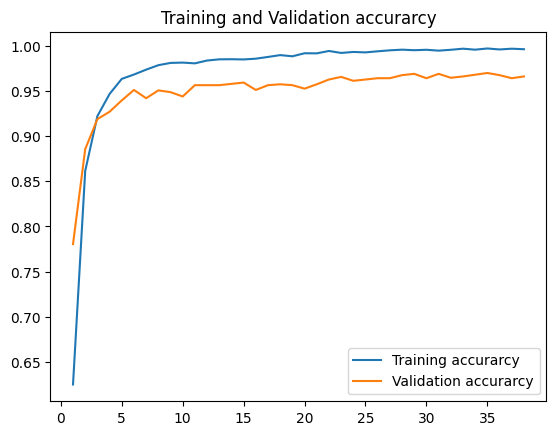

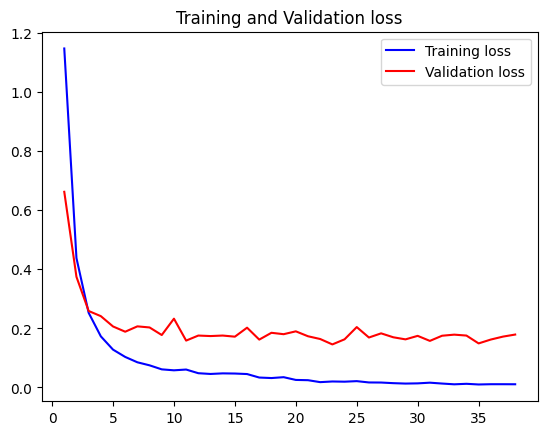

CPU times: user 450 ms, sys: 186 ms, total: 636 ms
Wall time: 429 ms


In [ ]:
%%time
temp = pd.DataFrame(history.history)
temp.to_csv('model_xception_history.csv', index=False)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, label='Training accurarcy')
plt.plot(epochs, val_acc, label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [ ]:
print('test images')
for filepath in glob.glob(train_path+'/*'):
    files = glob.glob(filepath + '/*')
    print(f"{len(files)} \t {Path(filepath).name}")

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    directory=train_path,
    target_size=(256, 256),
    color_mode="rgb",
    batch_size=1,
    #classes=['.'],
    #class_mode="categorical",
    class_mode=None,
    shuffle=False,
    seed=SEED)

test images
380 	 bacterial_leaf_streak
620 	 downy_mildew
1088 	 tungro
1442 	 dead_heart
479 	 bacterial_leaf_blight
1738 	 blast
965 	 brown_spot
1764 	 normal
337 	 bacterial_panicle_blight
1594 	 hispa
Found 10407 images belonging to 10 classes.


In [ ]:
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
#test_generator.reset()

model.load_weights('xception.weights.best.hdf5')
pred = model.predict_generator(test_generator,
                               steps=STEP_SIZE_TEST,
                               verbose=1)
pred_classes = np.argmax(pred, axis=1)

10407/10407 [==============================] - 101s 10ms/step


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

class_names = test_generator.class_indices.keys()
true_classes = test_generator.classes

acc = accuracy_score(true_classes, pred_classes)
print("xception Model Accuracy : {:.2f}%".format(acc * 100))

cls_report = classification_report(true_classes, pred_classes,
                                   target_names=class_names, digits=5)
print(cls_report)

xception Model Accuracy : 98.73%
                          precision    recall  f1-score   support

   bacterial_leaf_blight    0.98333   0.98539   0.98436       479
   bacterial_leaf_streak    0.98429   0.98947   0.98688       380
bacterial_panicle_blight    0.98521   0.98813   0.98667       337
                   blast    0.98340   0.98849   0.98594      1738
              brown_spot    0.99166   0.98549   0.98857       965
              dead_heart    0.99654   1.00000   0.99827      1442
            downy_mildew    0.96440   0.96129   0.96284       620
                   hispa    0.98811   0.99059   0.98935      1594
                  normal    0.99367   0.97959   0.98658      1764
                  tungro    0.98271   0.99265   0.98765      1088

                accuracy                        0.98732     10407
               macro avg    0.98533   0.98611   0.98571     10407
            weighted avg    0.98733   0.98732   0.98731     10407



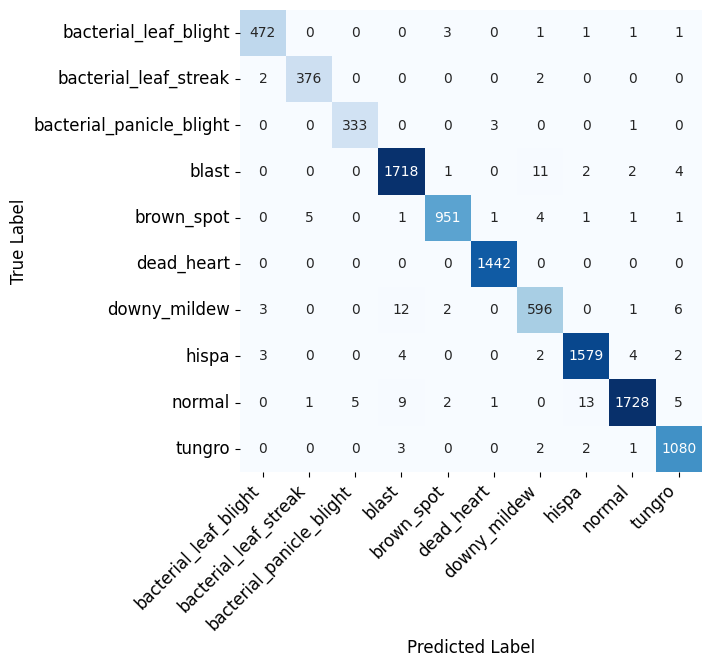

[[ 472    0    0    0    3    0    1    1    1    1]
 [   2  376    0    0    0    0    2    0    0    0]
 [   0    0  333    0    0    3    0    0    1    0]
 [   0    0    0 1718    1    0   11    2    2    4]
 [   0    5    0    1  951    1    4    1    1    1]
 [   0    0    0    0    0 1442    0    0    0    0]
 [   3    0    0   12    2    0  596    0    1    6]
 [   3    0    0    4    0    0    2 1579    4    2]
 [   0    1    5    9    2    1    0   13 1728    5]
 [   0    0    0    3    0    0    2    2    1 1080]]


In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get the names of the ten classes
class_names = test_generator.class_indices.keys()

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm,
        annot=True,
        square=True,
        xticklabels=class_names,
        yticklabels=class_names,
        fmt='d',
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
    #ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, rotation=45, ha="right")
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

plot_heatmap(true_classes, pred_classes, class_names, ax, title="CNN")

#fig.suptitle("Confusion Matrix Model Comparison", fontsize=12)
#fig.tight_layout()
#fig.subplots_adjust(top=1.25)
plt.show()
cm = confusion_matrix(true_classes, pred_classes)
print(cm)

In [ ]:
loss, acc = model.evaluate_generator(test_generator, steps=STEP_SIZE_TEST, verbose=1)
print(acc, loss)

10407/10407 [==============================] - 72s 7ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
0.0 0.0


In [ ]:
predicted_class_indices=np.argmax(pred,axis=1)
labels = (train_datagen.class_indices)

labels = (train_datagen.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

pd.Series(predictions).value_counts()

blast                       1747
normal                      1739
hispa                       1598
dead_heart                  1447
tungro                      1099
brown_spot                   959
downy_mildew                 618
bacterial_leaf_blight        480
bacterial_leaf_streak        382
bacterial_panicle_blight     338
Name: count, dtype: int64

In [ ]:
filenames=test_generator.filenames

results=pd.DataFrame({"image_id":filenames,
                      "label":predictions})
results.image_id = results.image_id.str.replace('./', '')
results.to_csv("submission.csv",index=False)
results.head()

,image_id,label
0,bacterial_leaf_blight/100023.jpg,bacterial_leaf_blight
1,bacterial_leaf_blight/100049.jpg,bacterial_leaf_blight
2,bacterial_leaf_blight/100126.jpg,bacterial_leaf_blight
3,bacterial_leaf_blight/100133.jpg,bacterial_leaf_blight
4,bacterial_leaf_blight/100148.jpg,bacterial_leaf_blight


In [ ]:
model_dics={
    'labels':labels,
    'model':model
}


model_dics

{'labels': {0: 'bacterial_leaf_blight',
  1: 'bacterial_leaf_streak',
  2: 'bacterial_panicle_blight',
  3: 'blast',
  4: 'brown_spot',
  5: 'dead_heart',
  6: 'downy_mildew',
  7: 'hispa',
  8: 'normal',
  9: 'tungro'},
 'model': <keras.src.engine.functional.Functional at 0x7dc080339780>}

In [ ]:
import pickle

with open('xception_model.pkl', 'wb') as file:
    pickle.dump(model_dics, file)